In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV

In [10]:
with open(r'C:\Users\kirki\Desktop\Siberian Alfa Hack Materials\train.parquet', 'rb') as f:
    train_df = pd.read_parquet(f, engine='pyarrow')
with open(r'C:\Users\kirki\Desktop\Siberian Alfa Hack Materials\test.parquet', 'rb') as g:
    test_df = pd.read_parquet(g, engine='pyarrow')

In [3]:
for col in train_df.columns.values.tolist():
        train_df[col] = train_df[col].fillna(0)

In [4]:
train_df.drop(["id", "target_1", "target_2"], axis=1, inplace=True)
cat_cols = [
    'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment'
]
train_df[cat_cols] = train_df[cat_cols].astype("category")

In [5]:
X = train_df.drop("total_target", axis=1)
y = train_df.total_target
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [6]:
tree_params = {'max_depth': range(38,42),
'max_features': [0.5, 0.7, 1]}

In [7]:
tree_grd = DecisionTreeClassifier(random_state=17)

In [8]:
tree_grid = GridSearchCV(tree_grd, tree_params, cv=5, n_jobs=-1, verbose=True)

In [9]:
%%time
tree_grid.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 1min 5s
Wall time: 26min 14s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': range(38, 42),
                         'max_features': [0.5, 0.7, 1]},
             verbose=True)

In [11]:
tree_grid.best_score_, tree_grid.best_params_

(0.91815625, {'max_depth': 39, 'max_features': 0.7})

In [16]:
tree = DecisionTreeClassifier(max_depth=39, max_features=0.7, random_state=42, class_weight='balanced')
tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=39, max_features=0.7,
                       random_state=42)

In [17]:
y_tree = tree.predict(x_val)

In [18]:
roc_auc_score(y_val, y_tree)

0.761432489798939

In [19]:
recall_score(y_val, y_tree)

0.5846123955702351

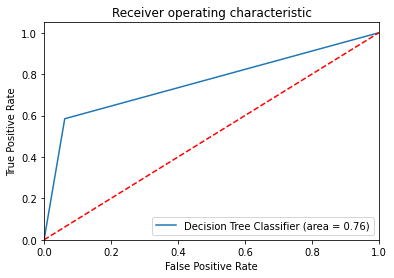

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
tree_roc_auc = roc_auc_score(y_val, y_tree)
fpr, tpr, thresholds = roc_curve(y_val, y_tree)
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classifier (area = %0.2f)' % tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Tree_ROC')
plt.show()

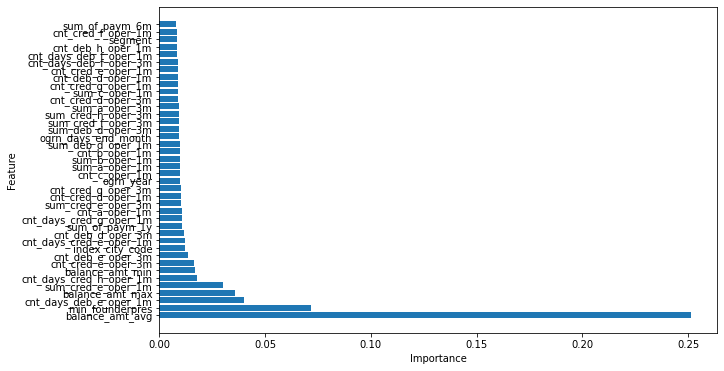

In [21]:
importances = tree.feature_importances_
features = train_df
feature_names = np.array(features.columns)

indices = np.argsort(importances)[::-1]
importances_sorted = importances[indices]
feature_names_sorted = feature_names[indices]

top_feature_names = feature_names_sorted[:40]
top_importances = importances_sorted[:40]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_feature_names)), top_importances, align='center')
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()